In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
#!g1.1
import torch
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt
import random
from IPython import display

SEED = 3407
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

In [5]:
#!g1.1
from hw_nv.datasets import prepare_dataloaders
from hw_nv.melspecs import MelSpectrogram, MelSpectrogramConfig

featurizer = MelSpectrogram(MelSpectrogramConfig())
train_loader, val_loader = prepare_dataloaders(batch_size=4)
test_batch = next(iter(train_loader))

# Training

Text: 'as to whether Oswald fell within the category of, quote, threats against the President, end quote, which should be referred to the Service.'
Predicted audio:


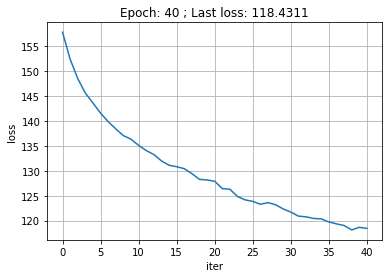

In [ ]:
#!g1.1
from hw_nv.models.hifigan import Generator

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model V3
model = Generator(
    channels_u=256,
    kernels_u=(16, 16, 8),
    kernels_r=(3, 5, 7),
    dilations_r=((1, 2), (2, 6), (3, 12))
).to(DEVICE)

n_iters = 6000
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.999)
l2_criterion = nn.MSELoss()
l1_criterion = nn.L1Loss()

loss_values = []

for i in range(n_iters):
    pred_wavs = model(test_batch["melspecs"].to(DEVICE)).squeeze(dim=1)
    real_wavs = test_batch["waveforms"].to(DEVICE)
    
    pred_mels = featurizer(pred_wavs.cpu()).to(DEVICE)
    real_mels = test_batch["melspecs"].to(DEVICE)

    max_len = min(real_wavs.shape[-1], pred_wavs.shape[-1])
    wav_loss = l2_criterion(pred_wavs[:, :max_len], real_wavs[:, :max_len])
    
    max_len = min(real_mels.shape[-1], pred_mels.shape[-1])
    mel_loss = l1_criterion(pred_mels[:, :, :max_len], real_mels[:, :, :max_len])
    
    loss = wav_loss + 45 * mel_loss
    
    loss_values.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i % 40 == 0:
        display.clear_output()
        text = test_batch["transcripts"][0]
        print(f"Text: '{text}'")
        print("Predicted audio:")
        display.display(display.Audio(pred_wavs[0].detach().cpu().numpy(), rate=22050))
        plt.figure()
        plt.title(f"Epoch: {i} ; Last loss: {round(loss.item(), 4)}")
        plt.plot(loss_values)
        plt.xlabel("iter")
        plt.ylabel("loss")
        plt.grid()
        plt.show()

torch.save(model.cpu().state_dict(), "checkpoint.pth")


In [15]:
#!g1.1
with torch.no_grad():
    predicted_wavs = gen(test_batch["melspecs"].to(DEVICE)).squeeze().cpu().numpy()

for text, real_wav, pred_wav in zip(test_batch["transcripts"], test_batch["waveforms"], predicted_wavs):
    print(f"Text: '{text}'")
    print("Predicted audio:")
    display.display(display.Audio(pred_wav, rate=22050))
    print("Source audio:")
    display.display(display.Audio(real_wav, rate=22050))
    print('-' * 99)


Text: 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'
Predicted audio:


Source audio:
---------------------------------------------------------------------------------------------------
Text: 'in being comparatively modern.'
Predicted audio:
Source audio:
---------------------------------------------------------------------------------------------------
Text: 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'
Predicted audio:
Source audio:


---------------------------------------------------------------------------------------------------
Text: 'produced the block books, which were the immediate predecessors of the true printed book,'
Predicted audio:
Source audio:
---------------------------------------------------------------------------------------------------


In [ ]:
#!g1.1
